In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import random
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split, KFold, cross_val_score

/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random_state=7

In [5]:
train = pd.read_csv("train.csv")
train = train.dropna()
train.drop(['Cabin'], 1, inplace=True) # drop the cabin column because it has a lot of null values
y = train['Survived']
train.drop(['Survived', 'PassengerId', 'Name', 'Ticket'], 1, inplace=True) # drop irrelevant columns
X = pd.get_dummies(train) # convert non-numerical variables to dummy variables
test = pd.read_csv("test.csv")
ids = test[['PassengerId']] # create a sub-dataset for submission file and saving it
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], 1, inplace=True) # drop the irrevant and keeping the rest
test.fillna(2, inplace=True) # fill (instead of drop) empty rows
test = pd.get_dummies(test)

In [44]:
# kf = KFold(n_splits=5, random_state=random_state)
# for train_index, test_index in kf.split(X):
#     print(f"Train: {train_index}, Test: {test_index}")
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=100, max_depth=2, random_state=random_state)
cv = cross_val_score(clf, X, y, cv=5)
print(f"CV Score: mean {np.mean(cv)}, std {np.std(cv)}, min {np.min(cv)}, max {np.max(cv)}")

CV Score: mean 0.7651651651651652, std 0.06365976813964302, min 0.6944444444444444, max 0.8611111111111112


In [54]:
#RUNNING grid search
parameters = {'n_estimators': np.linspace(100, 1000, 100, dtype=np.int),
             'min_samples_leaf': np.linspace(100, 300, 10, dtype=np.int),
             'max_depth': np.linspace(2, 5, 4, dtype=np.int)}
gs = GridSearchCV(clf, param_grid=parameters, cv=5, n_jobs=5)
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'n_estimators': array([ 100,  109, ...,  990, 1000]), 'min_samples_leaf': array([100, 122, 144, 166, 188, 211, 233, 255, 277, 300]), 'max_depth': array([2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [53]:
gs.best_params_, gs.best_score_

({'max_depth': 2, 'min_samples_leaf': 100, 'n_estimators': 100},
 0.6721311475409836)

In [65]:
clf_age = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, min_samples_leaf=100, max_depth=2, random_state=random_state)
cross_val_score(clf_age, X['Sex_male'].reshape(-1, 1), y, cv=5)

/Users/kdang/.virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


array([0.67567568, 0.67567568, 0.67567568, 0.66666667, 0.66666667])

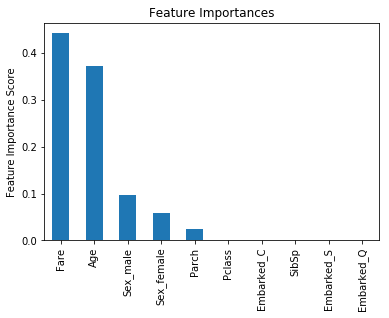

In [75]:
predictors = [c for c in X.columns]
gbm0 = GradientBoostingClassifier(random_state=random_state)
def model_fit(gbm0, X, predictors):
    gbm0.fit(X[predictors], y)
    train_prob = gbm0.predict_proba(X[predictors])[:, 1]
    cv_score = cross_val_score(gbm0, X[predictors], y, cv=5, scoring='roc_auc')
    predictions = gbm0.predict(X[predictors])
    metrics.accuracy_score(predictions, y)
    feature_importances = pd.Series(gbm0.feature_importances_, predictors).sort_values(ascending=False)
    feature_importances.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
model_fit(gbm0, X, predictors)

In [78]:
grid_params = {'n_estimators': np.linspace(20, 81, 10, dtype=np.int)}
gs = GridSearchCV(estimator=GradientBoostingClassifier(
    learning_rate=0.1, 
    min_samples_split=50, 
    min_samples_leaf=10, 
    max_depth=4, 
    subsample=0.8, 
    random_state=random_state), param_grid=grid_params, scoring='roc_auc', n_jobs=4, cv=5)
gs.fit(X[predictors], y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=7, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([20, 26, 33, 40, 47, 53, 60, 67, 74, 81])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [81]:
gs.grid_scores_

[mean: 0.82770, std: 0.07886, params: {'n_estimators': 20},
 mean: 0.82580, std: 0.06601, params: {'n_estimators': 26},
 mean: 0.82643, std: 0.06903, params: {'n_estimators': 33},
 mean: 0.81799, std: 0.07637, params: {'n_estimators': 40},
 mean: 0.81969, std: 0.07796, params: {'n_estimators': 47},
 mean: 0.81943, std: 0.08335, params: {'n_estimators': 53},
 mean: 0.81061, std: 0.07848, params: {'n_estimators': 60},
 mean: 0.81939, std: 0.08254, params: {'n_estimators': 67},
 mean: 0.81906, std: 0.08011, params: {'n_estimators': 74},
 mean: 0.81700, std: 0.08530, params: {'n_estimators': 81}]

In [27]:
results = ids.assign(Survived=predictions)
results.to_csv("titanic-results-random-forest.csv", index=False)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
rdf = RandomForestClassifier(n_estimators=30)
rdf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
predictions = rdf.predict(test)

In [26]:
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,